In [15]:
import CGA_onlyfuncions as cga
import numpy as np
from obj_func import obj_func
from read_instance import read_instance
import random
import seaborn as sns
from random import randint
import sys 

In [16]:
file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\a280_n279_bounded-strongly-corr_01.ttp","r")
#file=open(r"E:\monit\Documents\TTP\Instancias\a280-ttp\my_test.ttp","r")
dic=read_instance(file)


In [17]:
def create_knap_pop(dic,y,x):
    pop_knap=np.zeros((y,x,dic["number of items"]))
    for i in range(pop_knap.shape[0]):
        for l in range(pop_knap.shape[1]):
            for x in range(dic["number of items"]):
                item_pick=[]
                item_pick.append(random.randint(0, 1))
                item_pick2=np.array(item_pick)
                pop_knap[i,l]=item_pick2
    return pop_knap

In [18]:
def create_tsp_pop(dic,y,x):
    pop_tsp=np.zeros((y,x,dic["number cities"]-1))
    for i in range(pop_tsp.shape[0]):
        for l in range(pop_tsp.shape[1]):
            order_cities=list(range(2,dic["number cities"]+1 ))
            random.shuffle(order_cities)
            pop_tsp[i,l,:]=order_cities
    return pop_tsp

In [19]:
def fit_loop(dic,pop_tsp,pop_knap):
    fitness=np.zeros((Y,X))
    for i in range(Y):
        for l in range(X):
            fitness[i,l]=obj_func(dic,pop_tsp[i,l,:],pop_knap[i,l,:])
    return fitness

generation:  0  maximo:  -177597.54424246436
generation:  1  maximo:  -175931.91949802876
generation:  2  maximo:  -176148.659284621
generation:  3  maximo:  -176148.659284621
generation:  4  maximo:  -176148.659284621
generation:  5  maximo:  -176239.9223199093
generation:  6  maximo:  -176239.9223199093
generation:  7  maximo:  -176239.9223199093
generation:  8  maximo:  -174346.69958495526
generation:  9  maximo:  -174346.69958495526
generation:  10  maximo:  -174346.69958495526
generation:  11  maximo:  -174346.69958495526
generation:  12  maximo:  -174346.69958495526
generation:  13  maximo:  -174346.69958495526
generation:  14  maximo:  -173176.01179926947
generation:  15  maximo:  -172109.94663798332
generation:  16  maximo:  -172798.6452677617
generation:  17  maximo:  -172798.6452677617
generation:  18  maximo:  -171867.75732670407
generation:  19  maximo:  -171427.31941913828
generation:  20  maximo:  -171427.31941913828
generation:  21  maximo:  -171427.31941913828
generatio

generation:  179  maximo:  -151434.38850855757
generation:  180  maximo:  -151779.30159611732
generation:  181  maximo:  -151779.30159611732
generation:  182  maximo:  -151779.30159611732
generation:  183  maximo:  -151779.30159611732
generation:  184  maximo:  -151046.24563242734
generation:  185  maximo:  -151046.24563242734
generation:  186  maximo:  -151046.24563242734
generation:  187  maximo:  -151046.24563242734
generation:  188  maximo:  -151046.24563242734
generation:  189  maximo:  -151046.24563242734
generation:  190  maximo:  -151046.24563242734
generation:  191  maximo:  -151046.24563242734
generation:  192  maximo:  -150457.99730994308
generation:  193  maximo:  -147371.65815533543
generation:  194  maximo:  -147371.65815533543
generation:  195  maximo:  -147371.65815533543
generation:  196  maximo:  -147371.65815533543
generation:  197  maximo:  -147371.65815533543
generation:  198  maximo:  -147371.65815533543
generation:  199  maximo:  -147371.65815533543
generation:  

generation:  355  maximo:  -133168.06901085147
generation:  356  maximo:  -133168.06901085147
generation:  357  maximo:  -133193.6739908519
generation:  358  maximo:  -133193.6739908519
generation:  359  maximo:  -133168.06901085147
generation:  360  maximo:  -133168.06901085147
generation:  361  maximo:  -133168.06901085147
generation:  362  maximo:  -133168.06901085147
generation:  363  maximo:  -133168.06901085147
generation:  364  maximo:  -133000.74758781318
generation:  365  maximo:  -132899.13651804184
generation:  366  maximo:  -132899.13651804184
generation:  367  maximo:  -132899.13651804184
generation:  368  maximo:  -132899.13651804184
generation:  369  maximo:  -132899.13651804184
generation:  370  maximo:  -132899.13651804184
generation:  371  maximo:  -132817.8326035462
generation:  372  maximo:  -132696.4731670054
generation:  373  maximo:  -132428.88811447695
generation:  374  maximo:  -132428.88811447695
generation:  375  maximo:  -132428.88811447695
generation:  376 

generation:  530  maximo:  -120946.76275400375
generation:  531  maximo:  -120946.76275400375
generation:  532  maximo:  -120946.76275400375
generation:  533  maximo:  -120946.76275400375
generation:  534  maximo:  -120946.76275400375
generation:  535  maximo:  -120946.76275400375
generation:  536  maximo:  -120946.76275400375
generation:  537  maximo:  -120946.76275400375
generation:  538  maximo:  -120946.76275400375
generation:  539  maximo:  -120946.76275400375
generation:  540  maximo:  -120946.76275400375
generation:  541  maximo:  -119977.9380698057
generation:  542  maximo:  -120002.40311936435
generation:  543  maximo:  -120002.40311936435
generation:  544  maximo:  -119977.9380698057
generation:  545  maximo:  -119977.9380698057
generation:  546  maximo:  -120002.40311936435
generation:  547  maximo:  -120002.40311936435
generation:  548  maximo:  -120002.40311936435
generation:  549  maximo:  -120002.40311936435
generation:  550  maximo:  -120002.40311936435
generation:  551

generation:  705  maximo:  -112699.2136549266
generation:  706  maximo:  -112699.2136549266
generation:  707  maximo:  -112699.2136549266
generation:  708  maximo:  -112699.2136549266
generation:  709  maximo:  -112699.2136549266
generation:  710  maximo:  -112551.22403420162
generation:  711  maximo:  -112551.22403420162
generation:  712  maximo:  -112691.69498323876
generation:  713  maximo:  -112691.69498323876
generation:  714  maximo:  -112691.69498323876
generation:  715  maximo:  -112599.42715052638
generation:  716  maximo:  -111506.44869575393
generation:  717  maximo:  -111506.44869575393
generation:  718  maximo:  -111467.23968122297
generation:  719  maximo:  -111467.23968122297
generation:  720  maximo:  -111467.23968122297
generation:  721  maximo:  -111467.23968122297
generation:  722  maximo:  -111467.23968122297
generation:  723  maximo:  -111467.23968122297
generation:  724  maximo:  -111467.23968122297
generation:  725  maximo:  -111467.23968122297
generation:  726  

generation:  880  maximo:  -103315.39471138042
generation:  881  maximo:  -103315.39471138042
generation:  882  maximo:  -103315.39471138042
generation:  883  maximo:  -103315.39471138042
generation:  884  maximo:  -103315.39471138042
generation:  885  maximo:  -103315.39471138042
generation:  886  maximo:  -103315.39471138042
generation:  887  maximo:  -103044.95862819275
generation:  888  maximo:  -103044.95862819275
generation:  889  maximo:  -103044.95862819275
generation:  890  maximo:  -103044.95862819275
generation:  891  maximo:  -103044.95862819275
generation:  892  maximo:  -102505.1503170963
generation:  893  maximo:  -102505.1503170963
generation:  894  maximo:  -102438.59281940995
generation:  895  maximo:  -102438.59281940995
generation:  896  maximo:  -102438.59281940995
generation:  897  maximo:  -102438.59281940995
generation:  898  maximo:  -102438.59281940995
generation:  899  maximo:  -102438.59281940995
generation:  900  maximo:  -102438.59281940995
generation:  90

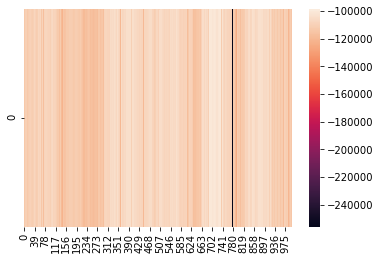

In [25]:
X=1000
Y=1
pop_knap=create_knap_pop(dic,Y,X)
pop_tsp=create_tsp_pop(dic,Y,X)
iterations=1000
mr=.1
maximos=[]
for p in range(iterations):
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    pop_knap=cga.crossover(fitness,pop_knap,Y,X,mr,True,False)
    pop_tsp=cga.crossover(fitness,pop_tsp,Y,X,mr,False,True)
    maximos.append(np.amax(fitness))
    print("generation: ",p, " maximo: ", np.amax(fitness))
fitness=fit_loop(dic,pop_tsp,pop_knap)
maximos.append(np.amax(fitness))
#print(maximos)
print(max(maximos),'maximo')
p1 = sns.heatmap(fitness)    


generation:  0  maximo:  -96448.25932421736
generation:  1  maximo:  -96448.25932421736
generation:  2  maximo:  -96448.25932421736
generation:  3  maximo:  -96448.25932421736
generation:  4  maximo:  -96448.25932421736
generation:  5  maximo:  -96127.96343202786
generation:  6  maximo:  -96127.96343202786
generation:  7  maximo:  -96127.96343202786
generation:  8  maximo:  -96127.96343202786
generation:  9  maximo:  -96127.96343202786
generation:  10  maximo:  -96127.96343202786
generation:  11  maximo:  -96065.52436178837
generation:  12  maximo:  -96065.52436178837
generation:  13  maximo:  -96065.52436178837
generation:  14  maximo:  -95650.28187069746
generation:  15  maximo:  -95650.28187069746
generation:  16  maximo:  -95650.28187069746
generation:  17  maximo:  -95650.28187069746
generation:  18  maximo:  -95650.28187069746
generation:  19  maximo:  -95650.28187069746
generation:  20  maximo:  -95650.28187069746
generation:  21  maximo:  -96094.95815203238
generation:  22  max

generation:  181  maximo:  -92144.21698783681
generation:  182  maximo:  -92144.21698783681
generation:  183  maximo:  -92144.21698783681
generation:  184  maximo:  -92144.21698783681
generation:  185  maximo:  -92144.21698783681
generation:  186  maximo:  -92144.21698783681
generation:  187  maximo:  -92144.21698783681
generation:  188  maximo:  -92144.21698783681
generation:  189  maximo:  -92144.21698783681
generation:  190  maximo:  -92144.21698783681
generation:  191  maximo:  -92144.21698783681
generation:  192  maximo:  -92115.60754490469
generation:  193  maximo:  -92115.60754490469
generation:  194  maximo:  -92115.60754490469
generation:  195  maximo:  -92115.60754490469
generation:  196  maximo:  -92120.01224386893
generation:  197  maximo:  -92120.01224386893
generation:  198  maximo:  -92120.01224386893
generation:  199  maximo:  -92115.60754490469
generation:  200  maximo:  -92115.60754490469
generation:  201  maximo:  -92115.60754490469
generation:  202  maximo:  -92115.

generation:  360  maximo:  -87653.32199626298
generation:  361  maximo:  -87653.32199626298
generation:  362  maximo:  -87653.32199626298
generation:  363  maximo:  -87653.32199626298
generation:  364  maximo:  -87653.32199626298
generation:  365  maximo:  -87653.32199626298
generation:  366  maximo:  -87653.32199626298
generation:  367  maximo:  -87653.32199626298
generation:  368  maximo:  -87468.72887597454
generation:  369  maximo:  -87468.72887597454
generation:  370  maximo:  -87468.72887597454
generation:  371  maximo:  -87398.91393160104
generation:  372  maximo:  -87398.91393160104
generation:  373  maximo:  -87398.91393160104
generation:  374  maximo:  -87398.91393160104
generation:  375  maximo:  -87398.91393160104
generation:  376  maximo:  -87398.91393160104
generation:  377  maximo:  -87398.91393160104
generation:  378  maximo:  -87398.91393160104
generation:  379  maximo:  -87398.91393160104
generation:  380  maximo:  -87398.91393160104
generation:  381  maximo:  -87398.

generation:  540  maximo:  -84933.94133248666
generation:  541  maximo:  -84933.94133248666
generation:  542  maximo:  -84933.94133248666
generation:  543  maximo:  -84933.94133248666
generation:  544  maximo:  -84933.94133248666
generation:  545  maximo:  -84933.94133248666
generation:  546  maximo:  -84933.94133248666
generation:  547  maximo:  -84937.4886252609
generation:  548  maximo:  -84644.52009580014
generation:  549  maximo:  -84085.63901925874
generation:  550  maximo:  -84085.63901925874
generation:  551  maximo:  -84085.63901925874
generation:  552  maximo:  -84085.63901925874
generation:  553  maximo:  -84085.63901925874
generation:  554  maximo:  -84085.63901925874
generation:  555  maximo:  -84085.63901925874
generation:  556  maximo:  -84085.63901925874
generation:  557  maximo:  -84085.63901925874
generation:  558  maximo:  -84085.63901925874
generation:  559  maximo:  -84085.63901925874
generation:  560  maximo:  -84085.63901925874
generation:  561  maximo:  -84085.6

generation:  719  maximo:  -79499.36799979556
generation:  720  maximo:  -79499.36799979556
generation:  721  maximo:  -79503.28512846559
generation:  722  maximo:  -79503.28512846559
generation:  723  maximo:  -79503.28512846559
generation:  724  maximo:  -79442.92608131608
generation:  725  maximo:  -79442.92608131608
generation:  726  maximo:  -79442.92608131608
generation:  727  maximo:  -79442.92608131608
generation:  728  maximo:  -79442.92608131608
generation:  729  maximo:  -79442.92608131608
generation:  730  maximo:  -79442.92608131608
generation:  731  maximo:  -79503.28512846559
generation:  732  maximo:  -79248.52017091357
generation:  733  maximo:  -78859.51520816682
generation:  734  maximo:  -79503.28512846559
generation:  735  maximo:  -79503.28512846559
generation:  736  maximo:  -79496.9445130266
generation:  737  maximo:  -79248.52017091357
generation:  738  maximo:  -79248.52017091357
generation:  739  maximo:  -79248.52017091357
generation:  740  maximo:  -79248.5

generation:  898  maximo:  -77729.26614519028
generation:  899  maximo:  -77729.26614519028
generation:  900  maximo:  -77729.26614519028
generation:  901  maximo:  -77621.21799930523
generation:  902  maximo:  -77621.21799930523
generation:  903  maximo:  -77451.85992265884
generation:  904  maximo:  -77451.85992265884
generation:  905  maximo:  -77451.85992265884
generation:  906  maximo:  -77451.85992265884
generation:  907  maximo:  -77451.85992265884
generation:  908  maximo:  -77451.85992265884
generation:  909  maximo:  -77451.85992265884
generation:  910  maximo:  -77451.85992265884
generation:  911  maximo:  -77451.85992265884
generation:  912  maximo:  -77418.32187394206
generation:  913  maximo:  -77418.32187394206
generation:  914  maximo:  -77418.32187394206
generation:  915  maximo:  -77418.32187394206
generation:  916  maximo:  -77418.32187394206
generation:  917  maximo:  -77418.32187394206
generation:  918  maximo:  -77418.32187394206
generation:  919  maximo:  -77418.

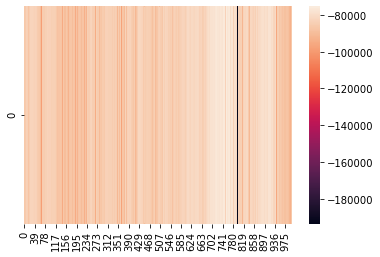

In [27]:
iterations=1000
maximos=[]
for p in range(iterations):
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    pop_knap=cga.crossover(fitness,pop_knap,Y,X,mr,True,False)
    pop_tsp=cga.crossover(fitness,pop_tsp,Y,X,mr,False,True)
    maximos.append(np.amax(fitness))
    print("generation: ",p, " maximo: ", np.amax(fitness))
fitness=fit_loop(dic,pop_tsp,pop_knap)
maximos.append(np.amax(fitness))
#print(maximos)
print(max(maximos),'maximo')
p1 = sns.heatmap(fitness)    

    
    

In [ ]:
iterations=10000
maximos=[]
for p in range(iterations):
    fitness=fit_loop(dic,pop_tsp,pop_knap)
    pop_knap=cga.crossover(fitness,pop_knap,Y,X,mr,True,False)
    pop_tsp=cga.crossover(fitness,pop_tsp,Y,X,mr,False,True)
    maximos.append(np.amax(fitness))
    print("generation: ",p, " maximo: ", np.amax(fitness))
fitness=fit_loop(dic,pop_tsp,pop_knap)
maximos.append(np.amax(fitness))
#print(maximos)
print(max(maximos),'maximo')
p1 = sns.heatmap(fitness)    

generation:  0  maximo:  -75340.51434564791
generation:  1  maximo:  -75340.51434564791
generation:  2  maximo:  -75340.51434564791
generation:  3  maximo:  -75340.51434564791
generation:  4  maximo:  -75340.51434564791
generation:  5  maximo:  -75340.51434564791
generation:  6  maximo:  -75340.51434564791
generation:  7  maximo:  -75340.51434564791
generation:  8  maximo:  -75340.51434564791
generation:  9  maximo:  -75340.51434564791
generation:  10  maximo:  -75340.51434564791
generation:  11  maximo:  -75340.51434564791
generation:  12  maximo:  -75340.51434564791
generation:  13  maximo:  -75340.51434564791
generation:  14  maximo:  -75340.51434564791
generation:  15  maximo:  -75340.51434564791
generation:  16  maximo:  -75216.65586877803
generation:  17  maximo:  -75340.51434564791
generation:  18  maximo:  -75340.51434564791
generation:  19  maximo:  -75340.51434564791
generation:  20  maximo:  -75340.51434564791
generation:  21  maximo:  -75340.51434564791
generation:  22  max

generation:  181  maximo:  -74342.31854423785
generation:  182  maximo:  -74342.31854423785
generation:  183  maximo:  -74342.31854423785
generation:  184  maximo:  -74342.31854423785
generation:  185  maximo:  -74342.31854423785
generation:  186  maximo:  -74342.31854423785
generation:  187  maximo:  -74041.71760868462
generation:  188  maximo:  -74342.31854423785
generation:  189  maximo:  -74342.31854423785
generation:  190  maximo:  -74278.94049388041
generation:  191  maximo:  -74386.98066823259
generation:  192  maximo:  -74386.98066823259
generation:  193  maximo:  -74386.98066823259
generation:  194  maximo:  -74386.98066823259
generation:  195  maximo:  -74386.98066823259
generation:  196  maximo:  -73933.82844982726
generation:  197  maximo:  -73933.82844982726
generation:  198  maximo:  -73933.82844982726
generation:  199  maximo:  -73933.82844982726
generation:  200  maximo:  -73796.66869071905
generation:  201  maximo:  -73796.66869071905
generation:  202  maximo:  -73796.

generation:  361  maximo:  -72701.25254596835
generation:  362  maximo:  -72701.25254596835
generation:  363  maximo:  -72701.25254596835
generation:  364  maximo:  -72701.25254596835
generation:  365  maximo:  -72701.25254596835
generation:  366  maximo:  -72701.25254596835
generation:  367  maximo:  -72701.25254596835
generation:  368  maximo:  -72569.98369851746
generation:  369  maximo:  -72569.98369851746
generation:  370  maximo:  -72569.98369851746
generation:  371  maximo:  -72549.02815924452
generation:  372  maximo:  -72549.02815924452
generation:  373  maximo:  -72013.38441137473
generation:  374  maximo:  -72031.82912720171
generation:  375  maximo:  -72031.82912720171
generation:  376  maximo:  -72013.38441137473
generation:  377  maximo:  -72013.38441137473
generation:  378  maximo:  -72013.38441137473
generation:  379  maximo:  -71854.17398178852
generation:  380  maximo:  -72013.38441137473
generation:  381  maximo:  -71978.86460371682
generation:  382  maximo:  -71978.

generation:  540  maximo:  -70784.04742818132
generation:  541  maximo:  -70508.86600840175
generation:  542  maximo:  -70784.04742818132
generation:  543  maximo:  -70784.04742818132
generation:  544  maximo:  -70784.04742818132
generation:  545  maximo:  -70776.45459878245
generation:  546  maximo:  -70776.45459878245
generation:  547  maximo:  -70776.45459878245
generation:  548  maximo:  -70776.45459878245
generation:  549  maximo:  -70776.45459878245
generation:  550  maximo:  -70776.45459878245
generation:  551  maximo:  -70776.45459878245
generation:  552  maximo:  -70776.45459878245
generation:  553  maximo:  -70776.45459878245
generation:  554  maximo:  -70776.45459878245
generation:  555  maximo:  -70776.45459878245
generation:  556  maximo:  -70570.01298193961
generation:  557  maximo:  -70570.01298193961
generation:  558  maximo:  -70570.01298193961
generation:  559  maximo:  -70570.01298193961
generation:  560  maximo:  -70570.01298193961
generation:  561  maximo:  -70570.

generation:  719  maximo:  -68339.66085354511
generation:  720  maximo:  -68339.66085354511
generation:  721  maximo:  -68339.66085354511
generation:  722  maximo:  -68339.66085354511
generation:  723  maximo:  -68339.66085354511
generation:  724  maximo:  -68339.66085354511
generation:  725  maximo:  -68311.0923071569
generation:  726  maximo:  -68311.0923071569
generation:  727  maximo:  -68311.0923071569
generation:  728  maximo:  -68311.0923071569
generation:  729  maximo:  -68311.0923071569
generation:  730  maximo:  -68311.0923071569
generation:  731  maximo:  -68211.55433678647
generation:  732  maximo:  -68211.55433678647
generation:  733  maximo:  -68211.55433678647
generation:  734  maximo:  -68211.55433678647
generation:  735  maximo:  -68207.45024368167
generation:  736  maximo:  -68211.55433678647
generation:  737  maximo:  -68211.55433678647
generation:  738  maximo:  -68211.55433678647
generation:  739  maximo:  -68211.55433678647
generation:  740  maximo:  -68211.554336

generation:  898  maximo:  -65987.53406144136
generation:  899  maximo:  -65987.53406144136
generation:  900  maximo:  -65987.53406144136
generation:  901  maximo:  -65987.53406144136
generation:  902  maximo:  -65987.53406144136
generation:  903  maximo:  -65987.53406144136
generation:  904  maximo:  -65987.53406144136
generation:  905  maximo:  -66115.4896685468
generation:  906  maximo:  -65987.53406144136
generation:  907  maximo:  -65969.0787094826
generation:  908  maximo:  -65969.0787094826
generation:  909  maximo:  -65969.0787094826
generation:  910  maximo:  -65969.0787094826
generation:  911  maximo:  -65969.0787094826
generation:  912  maximo:  -65969.0787094826
generation:  913  maximo:  -65969.0787094826
generation:  914  maximo:  -65969.0787094826
generation:  915  maximo:  -65969.0787094826
generation:  916  maximo:  -65969.0787094826
generation:  917  maximo:  -65969.0787094826
generation:  918  maximo:  -65969.0787094826
generation:  919  maximo:  -65969.0787094826
ge

generation:  1074  maximo:  -64022.199101074366
generation:  1075  maximo:  -63883.95514096953
generation:  1076  maximo:  -63883.95514096953
generation:  1077  maximo:  -63883.95514096953
generation:  1078  maximo:  -63883.95514096953
generation:  1079  maximo:  -63883.95514096953
generation:  1080  maximo:  -63883.95514096953
generation:  1081  maximo:  -63883.95514096953
generation:  1082  maximo:  -63883.95514096953
generation:  1083  maximo:  -63883.95514096953
generation:  1084  maximo:  -64022.199101074366
generation:  1085  maximo:  -64022.199101074366
generation:  1086  maximo:  -64022.199101074366
generation:  1087  maximo:  -64022.199101074366
generation:  1088  maximo:  -63302.61957797548
generation:  1089  maximo:  -63302.61957797548
generation:  1090  maximo:  -63302.61957797548
generation:  1091  maximo:  -63302.61957797548
generation:  1092  maximo:  -63302.61957797548
generation:  1093  maximo:  -63302.61957797548
generation:  1094  maximo:  -63302.61957797548
generati

generation:  1249  maximo:  -62650.66571261213
generation:  1250  maximo:  -62650.66571261213
generation:  1251  maximo:  -62650.66571261213
generation:  1252  maximo:  -62650.66571261213
generation:  1253  maximo:  -62650.66571261213
generation:  1254  maximo:  -62650.66571261213
generation:  1255  maximo:  -62766.27522218229
generation:  1256  maximo:  -62766.27522218229
generation:  1257  maximo:  -62733.29943361148
generation:  1258  maximo:  -62523.949650003444
generation:  1259  maximo:  -62523.949650003444
generation:  1260  maximo:  -62733.29943361148
generation:  1261  maximo:  -62733.29943361148
generation:  1262  maximo:  -62733.29943361148
generation:  1263  maximo:  -62733.29943361148
generation:  1264  maximo:  -62733.29943361148
generation:  1265  maximo:  -62766.27522218229
generation:  1266  maximo:  -62766.27522218229
generation:  1267  maximo:  -62766.27522218229
generation:  1268  maximo:  -62766.27522218229
generation:  1269  maximo:  -62766.27522218229
generation:

generation:  1424  maximo:  -61607.30545073534
generation:  1425  maximo:  -61607.30545073534
generation:  1426  maximo:  -61653.87307996505
generation:  1427  maximo:  -61759.081714360276
generation:  1428  maximo:  -61607.30545073534
generation:  1429  maximo:  -61607.30545073534
generation:  1430  maximo:  -61607.30545073534
generation:  1431  maximo:  -61607.30545073534
generation:  1432  maximo:  -61607.30545073534
generation:  1433  maximo:  -61607.30545073534
generation:  1434  maximo:  -61607.30545073534
generation:  1435  maximo:  -61607.30545073534
generation:  1436  maximo:  -61607.30545073534
generation:  1437  maximo:  -61607.30545073534
generation:  1438  maximo:  -61607.30545073534
generation:  1439  maximo:  -61607.30545073534
generation:  1440  maximo:  -61607.30545073534
generation:  1441  maximo:  -61390.58396417748
generation:  1442  maximo:  -61390.58396417748
generation:  1443  maximo:  -61390.58396417748
generation:  1444  maximo:  -61390.58396417748
generation: 

generation:  1598  maximo:  -60693.76014198162
generation:  1599  maximo:  -60693.76014198162
generation:  1600  maximo:  -60693.76014198162
generation:  1601  maximo:  -60693.76014198162
generation:  1602  maximo:  -60693.76014198162
generation:  1603  maximo:  -60693.76014198162
generation:  1604  maximo:  -60693.76014198162
generation:  1605  maximo:  -60693.76014198162
generation:  1606  maximo:  -60693.76014198162
generation:  1607  maximo:  -60693.76014198162
generation:  1608  maximo:  -60693.76014198162
generation:  1609  maximo:  -60693.76014198162
generation:  1610  maximo:  -60693.76014198162
generation:  1611  maximo:  -60693.76014198162
generation:  1612  maximo:  -60693.76014198162
generation:  1613  maximo:  -60693.76014198162
generation:  1614  maximo:  -60693.76014198162
generation:  1615  maximo:  -60339.39084591235
generation:  1616  maximo:  -60339.39084591235
generation:  1617  maximo:  -60339.39084591235
generation:  1618  maximo:  -60339.39084591235
generation:  

generation:  1773  maximo:  -59737.364693753596
generation:  1774  maximo:  -59737.364693753596
generation:  1775  maximo:  -59737.364693753596
generation:  1776  maximo:  -59379.76701444645
generation:  1777  maximo:  -59379.76701444645
generation:  1778  maximo:  -59379.76701444645
generation:  1779  maximo:  -59379.76701444645
generation:  1780  maximo:  -59379.76701444645
generation:  1781  maximo:  -59379.76701444645
generation:  1782  maximo:  -59379.76701444645
generation:  1783  maximo:  -59379.76701444645
generation:  1784  maximo:  -59379.76701444645
generation:  1785  maximo:  -59379.76701444645
generation:  1786  maximo:  -59379.76701444645
generation:  1787  maximo:  -59379.76701444645
generation:  1788  maximo:  -59379.76701444645
generation:  1789  maximo:  -59379.76701444645
generation:  1790  maximo:  -59379.76701444645
generation:  1791  maximo:  -59379.76701444645
generation:  1792  maximo:  -59379.76701444645
generation:  1793  maximo:  -59379.76701444645
generation

generation:  1947  maximo:  -58349.39967503688
generation:  1948  maximo:  -58349.39967503688
generation:  1949  maximo:  -58349.39967503688
generation:  1950  maximo:  -58349.39967503688
generation:  1951  maximo:  -58412.015378470984
generation:  1952  maximo:  -58412.015378470984
generation:  1953  maximo:  -58412.015378470984
generation:  1954  maximo:  -58412.015378470984
generation:  1955  maximo:  -58412.015378470984
generation:  1956  maximo:  -58412.015378470984
generation:  1957  maximo:  -58412.015378470984
generation:  1958  maximo:  -58412.015378470984
generation:  1959  maximo:  -58412.015378470984
generation:  1960  maximo:  -58412.015378470984
generation:  1961  maximo:  -58412.015378470984
generation:  1962  maximo:  -58412.015378470984
generation:  1963  maximo:  -58412.015378470984
generation:  1964  maximo:  -58412.015378470984
generation:  1965  maximo:  -58412.015378470984
generation:  1966  maximo:  -58412.015378470984
generation:  1967  maximo:  -58412.015378470

generation:  2121  maximo:  -57551.9029518809
generation:  2122  maximo:  -57551.9029518809
generation:  2123  maximo:  -57551.9029518809
generation:  2124  maximo:  -57551.9029518809
generation:  2125  maximo:  -57162.54950133084
generation:  2126  maximo:  -57162.54950133084
generation:  2127  maximo:  -57162.54950133084
generation:  2128  maximo:  -57162.54950133084
generation:  2129  maximo:  -57162.54950133084
generation:  2130  maximo:  -57162.54950133084
generation:  2131  maximo:  -57162.54950133084
generation:  2132  maximo:  -57162.54950133084
generation:  2133  maximo:  -57162.54950133084
generation:  2134  maximo:  -57243.27748987249
generation:  2135  maximo:  -57243.27748987249
generation:  2136  maximo:  -57243.27748987249
generation:  2137  maximo:  -57243.27748987249
generation:  2138  maximo:  -57243.27748987249
generation:  2139  maximo:  -57243.27748987249
generation:  2140  maximo:  -57243.27748987249
generation:  2141  maximo:  -57243.27748987249
generation:  2142

generation:  2293  maximo:  -56578.229606661276
generation:  2294  maximo:  -56578.229606661276
generation:  2295  maximo:  -55992.14852375796
generation:  2296  maximo:  -55992.14852375796
generation:  2297  maximo:  -55992.14852375796
generation:  2298  maximo:  -55992.14852375796
generation:  2299  maximo:  -55992.14852375796
generation:  2300  maximo:  -55992.14852375796
generation:  2301  maximo:  -55992.14852375796
generation:  2302  maximo:  -55992.14852375796
generation:  2303  maximo:  -55992.14852375796
generation:  2304  maximo:  -55992.14852375796
generation:  2305  maximo:  -55992.14852375796
generation:  2306  maximo:  -55992.14852375796
generation:  2307  maximo:  -55992.14852375796
generation:  2308  maximo:  -55992.14852375796
generation:  2309  maximo:  -55992.14852375796
generation:  2310  maximo:  -55992.14852375796
generation:  2311  maximo:  -55992.14852375796
generation:  2312  maximo:  -55992.14852375796
generation:  2313  maximo:  -55992.14852375796
generation:

generation:  2468  maximo:  -55438.6648012308
generation:  2469  maximo:  -55438.6648012308
generation:  2470  maximo:  -55438.6648012308
generation:  2471  maximo:  -55424.48344592731
generation:  2472  maximo:  -55424.48344592731
generation:  2473  maximo:  -55438.6648012308
generation:  2474  maximo:  -55380.90974827114
generation:  2475  maximo:  -55321.71996370563
generation:  2476  maximo:  -55321.71996370563
generation:  2477  maximo:  -55321.71996370563
generation:  2478  maximo:  -55321.71996370563
generation:  2479  maximo:  -55321.71996370563
generation:  2480  maximo:  -55321.71996370563
generation:  2481  maximo:  -55321.71996370563
generation:  2482  maximo:  -55321.71996370563
generation:  2483  maximo:  -55321.71996370563
generation:  2484  maximo:  -55321.71996370563
generation:  2485  maximo:  -55321.71996370563
generation:  2486  maximo:  -55321.71996370563
generation:  2487  maximo:  -55321.71996370563
generation:  2488  maximo:  -55321.71996370563
generation:  2489

generation:  2643  maximo:  -53821.260902610666
generation:  2644  maximo:  -53821.260902610666
generation:  2645  maximo:  -53821.260902610666
generation:  2646  maximo:  -53821.260902610666
generation:  2647  maximo:  -53821.260902610666
generation:  2648  maximo:  -53821.260902610666
generation:  2649  maximo:  -53821.260902610666
generation:  2650  maximo:  -53821.260902610666
generation:  2651  maximo:  -53821.260902610666
generation:  2652  maximo:  -53821.260902610666
generation:  2653  maximo:  -53821.260902610666
generation:  2654  maximo:  -53821.260902610666
generation:  2655  maximo:  -53821.260902610666
generation:  2656  maximo:  -53821.260902610666
generation:  2657  maximo:  -53821.260902610666
generation:  2658  maximo:  -53821.260902610666
generation:  2659  maximo:  -53821.260902610666
generation:  2660  maximo:  -53821.260902610666
generation:  2661  maximo:  -53821.260902610666
generation:  2662  maximo:  -53821.260902610666
generation:  2663  maximo:  -53821.26090

generation:  2815  maximo:  -54021.983468979975
generation:  2816  maximo:  -54021.983468979975
generation:  2817  maximo:  -54021.983468979975
generation:  2818  maximo:  -54021.983468979975
generation:  2819  maximo:  -54021.983468979975
generation:  2820  maximo:  -54021.983468979975
generation:  2821  maximo:  -54021.983468979975
generation:  2822  maximo:  -54021.983468979975
generation:  2823  maximo:  -54021.983468979975
generation:  2824  maximo:  -54021.983468979975
generation:  2825  maximo:  -54021.983468979975
generation:  2826  maximo:  -54021.983468979975
generation:  2827  maximo:  -54021.983468979975
generation:  2828  maximo:  -54021.983468979975
generation:  2829  maximo:  -53940.92774682972
generation:  2830  maximo:  -54021.983468979975
generation:  2831  maximo:  -54019.00538010559
generation:  2832  maximo:  -54019.00538010559
generation:  2833  maximo:  -54019.00538010559
generation:  2834  maximo:  -54019.00538010559
generation:  2835  maximo:  -54019.0053801055

generation:  2988  maximo:  -53330.474894017185
generation:  2989  maximo:  -52485.45333748737
generation:  2990  maximo:  -52485.45333748737
generation:  2991  maximo:  -52485.45333748737
generation:  2992  maximo:  -52485.45333748737
generation:  2993  maximo:  -52485.45333748737
generation:  2994  maximo:  -52485.45333748737
generation:  2995  maximo:  -52485.45333748737
generation:  2996  maximo:  -52485.45333748737
generation:  2997  maximo:  -52485.45333748737
generation:  2998  maximo:  -52485.45333748737
generation:  2999  maximo:  -52485.45333748737
generation:  3000  maximo:  -52485.45333748737
generation:  3001  maximo:  -52485.45333748737
generation:  3002  maximo:  -52135.18687164136
generation:  3003  maximo:  -52135.18687164136
generation:  3004  maximo:  -52135.18687164136
generation:  3005  maximo:  -52135.18687164136
generation:  3006  maximo:  -52135.18687164136
generation:  3007  maximo:  -52135.18687164136
generation:  3008  maximo:  -52135.18687164136
generation: 

generation:  3163  maximo:  -51492.12324017157
generation:  3164  maximo:  -51492.12324017157
generation:  3165  maximo:  -51492.12324017157
generation:  3166  maximo:  -51492.12324017157
generation:  3167  maximo:  -51492.12324017157
generation:  3168  maximo:  -51492.12324017157
generation:  3169  maximo:  -51492.12324017157
generation:  3170  maximo:  -51492.12324017157
generation:  3171  maximo:  -51492.12324017157
generation:  3172  maximo:  -51492.12324017157
generation:  3173  maximo:  -51492.12324017157
generation:  3174  maximo:  -51492.12324017157
generation:  3175  maximo:  -51492.12324017157
generation:  3176  maximo:  -51492.12324017157
generation:  3177  maximo:  -51492.12324017157
generation:  3178  maximo:  -51492.12324017157
generation:  3179  maximo:  -51492.12324017157
generation:  3180  maximo:  -51492.12324017157
generation:  3181  maximo:  -51492.12324017157
generation:  3182  maximo:  -51492.12324017157
generation:  3183  maximo:  -51492.12324017157
generation:  

generation:  3336  maximo:  -50669.33395894762
generation:  3337  maximo:  -50669.33395894762
generation:  3338  maximo:  -50669.33395894762
generation:  3339  maximo:  -50669.33395894762
generation:  3340  maximo:  -50669.33395894762
generation:  3341  maximo:  -50669.33395894762
generation:  3342  maximo:  -50669.33395894762
generation:  3343  maximo:  -50669.33395894762
generation:  3344  maximo:  -50669.33395894762
generation:  3345  maximo:  -50669.33395894762
generation:  3346  maximo:  -50669.33395894762
generation:  3347  maximo:  -50669.33395894762
generation:  3348  maximo:  -50669.33395894762
generation:  3349  maximo:  -50669.33395894762
generation:  3350  maximo:  -50669.33395894762
generation:  3351  maximo:  -50669.33395894762
generation:  3352  maximo:  -50669.33395894762
generation:  3353  maximo:  -50669.33395894762
generation:  3354  maximo:  -50669.33395894762
generation:  3355  maximo:  -50669.33395894762
generation:  3356  maximo:  -50669.33395894762
generation:  

generation:  3511  maximo:  -50434.47595466852
generation:  3512  maximo:  -50434.47595466852
generation:  3513  maximo:  -50434.47595466852
generation:  3514  maximo:  -50434.47595466852
generation:  3515  maximo:  -50434.47595466852
generation:  3516  maximo:  -50415.08533467812
generation:  3517  maximo:  -50434.47595466852
generation:  3518  maximo:  -50434.47595466852
generation:  3519  maximo:  -50434.47595466852
generation:  3520  maximo:  -50434.47595466852
generation:  3521  maximo:  -50434.47595466852
generation:  3522  maximo:  -50434.47595466852
generation:  3523  maximo:  -50434.47595466852
generation:  3524  maximo:  -50434.47595466852
generation:  3525  maximo:  -50434.47595466852
generation:  3526  maximo:  -50434.47595466852
generation:  3527  maximo:  -50434.47595466852
generation:  3528  maximo:  -50434.47595466852
generation:  3529  maximo:  -50434.47595466852
generation:  3530  maximo:  -50434.47595466852
generation:  3531  maximo:  -50434.47595466852
generation:  

generation:  3686  maximo:  -49957.32503108842
generation:  3687  maximo:  -50034.62062839379
generation:  3688  maximo:  -49957.32503108842
generation:  3689  maximo:  -49957.32503108842
generation:  3690  maximo:  -49957.32503108842
generation:  3691  maximo:  -49957.32503108842
generation:  3692  maximo:  -49957.32503108842
generation:  3693  maximo:  -49957.32503108842
generation:  3694  maximo:  -49957.32503108842
generation:  3695  maximo:  -49957.32503108842
generation:  3696  maximo:  -49957.32503108842
generation:  3697  maximo:  -49957.32503108842
generation:  3698  maximo:  -49957.32503108842
generation:  3699  maximo:  -49957.32503108842
generation:  3700  maximo:  -49957.32503108842
generation:  3701  maximo:  -49957.32503108842
generation:  3702  maximo:  -49957.32503108842
generation:  3703  maximo:  -49956.72315685147
generation:  3704  maximo:  -49956.72315685147
generation:  3705  maximo:  -49956.72315685147
generation:  3706  maximo:  -49956.72315685147
generation:  

generation:  3861  maximo:  -49778.92789553797
generation:  3862  maximo:  -49778.92789553797
generation:  3863  maximo:  -49778.92789553797
generation:  3864  maximo:  -49778.92789553797
generation:  3865  maximo:  -49778.92789553797
generation:  3866  maximo:  -49778.92789553797
generation:  3867  maximo:  -49778.92789553797
generation:  3868  maximo:  -49778.92789553797
generation:  3869  maximo:  -49690.187525404064
generation:  3870  maximo:  -49396.42639354609
generation:  3871  maximo:  -49554.228260070886
generation:  3872  maximo:  -49554.228260070886
generation:  3873  maximo:  -49554.228260070886
generation:  3874  maximo:  -49554.228260070886
generation:  3875  maximo:  -49554.228260070886
generation:  3876  maximo:  -49554.228260070886
generation:  3877  maximo:  -49554.228260070886
generation:  3878  maximo:  -49554.228260070886
generation:  3879  maximo:  -49554.228260070886
generation:  3880  maximo:  -49554.228260070886
generation:  3881  maximo:  -49554.228260070886
g

generation:  4035  maximo:  -48878.707868521684
generation:  4036  maximo:  -48878.707868521684
generation:  4037  maximo:  -48878.707868521684
generation:  4038  maximo:  -48878.707868521684
generation:  4039  maximo:  -48878.707868521684
generation:  4040  maximo:  -48878.707868521684
generation:  4041  maximo:  -48878.707868521684
generation:  4042  maximo:  -48878.707868521684
generation:  4043  maximo:  -48878.707868521684
generation:  4044  maximo:  -48878.707868521684
generation:  4045  maximo:  -48878.707868521684
generation:  4046  maximo:  -48878.707868521684
generation:  4047  maximo:  -48878.707868521684
generation:  4048  maximo:  -48878.707868521684
generation:  4049  maximo:  -48878.707868521684
generation:  4050  maximo:  -48878.707868521684
generation:  4051  maximo:  -48878.707868521684
generation:  4052  maximo:  -48878.707868521684
generation:  4053  maximo:  -48878.707868521684
generation:  4054  maximo:  -48878.707868521684
generation:  4055  maximo:  -48878.70786

generation:  4208  maximo:  -48452.46214313837
generation:  4209  maximo:  -48452.46214313837
generation:  4210  maximo:  -48452.46214313837
generation:  4211  maximo:  -48452.46214313837
generation:  4212  maximo:  -48452.46214313837
generation:  4213  maximo:  -48452.46214313837
generation:  4214  maximo:  -48452.46214313837
generation:  4215  maximo:  -48452.46214313837
generation:  4216  maximo:  -48452.46214313837
generation:  4217  maximo:  -48412.14713305331
generation:  4218  maximo:  -48410.894927724905
generation:  4219  maximo:  -48410.894927724905
generation:  4220  maximo:  -48410.894927724905
generation:  4221  maximo:  -48410.894927724905
generation:  4222  maximo:  -48370.30464163594
generation:  4223  maximo:  -48285.29428821588
generation:  4224  maximo:  -48285.29428821588
generation:  4225  maximo:  -48285.29428821588
generation:  4226  maximo:  -48285.29428821588
generation:  4227  maximo:  -48285.29428821588
generation:  4228  maximo:  -48285.29428821588
generatio

generation:  4382  maximo:  -47459.67780559436
generation:  4383  maximo:  -47459.67780559436
generation:  4384  maximo:  -47459.67780559436
generation:  4385  maximo:  -47459.67780559436
generation:  4386  maximo:  -47459.67780559436
generation:  4387  maximo:  -47459.67780559436
generation:  4388  maximo:  -47459.67780559436
generation:  4389  maximo:  -47459.67780559436
generation:  4390  maximo:  -47459.67780559436
generation:  4391  maximo:  -47459.67780559436
generation:  4392  maximo:  -47459.67780559436
generation:  4393  maximo:  -47459.67780559436
generation:  4394  maximo:  -47459.67780559436
generation:  4395  maximo:  -47459.67780559436
generation:  4396  maximo:  -47459.67780559436
generation:  4397  maximo:  -47459.67780559436
generation:  4398  maximo:  -47459.67780559436
generation:  4399  maximo:  -47459.67780559436
generation:  4400  maximo:  -47459.67780559436
generation:  4401  maximo:  -47459.67780559436
generation:  4402  maximo:  -47459.67780559436
generation:  

generation:  4556  maximo:  -47256.87963004883
generation:  4557  maximo:  -47256.87963004883
generation:  4558  maximo:  -47256.87963004883
generation:  4559  maximo:  -47256.87963004883
generation:  4560  maximo:  -47256.87963004883
generation:  4561  maximo:  -47244.46928046348
generation:  4562  maximo:  -47244.46928046348
generation:  4563  maximo:  -47244.46928046348
generation:  4564  maximo:  -47244.46928046348
generation:  4565  maximo:  -47244.46928046348
generation:  4566  maximo:  -47244.46928046348
generation:  4567  maximo:  -47244.46928046348
generation:  4568  maximo:  -47244.46928046348
generation:  4569  maximo:  -47232.980307595586
generation:  4570  maximo:  -47232.980307595586
generation:  4571  maximo:  -47232.980307595586
generation:  4572  maximo:  -47232.980307595586
generation:  4573  maximo:  -47033.9000844776
generation:  4574  maximo:  -47033.9000844776
generation:  4575  maximo:  -47033.9000844776
generation:  4576  maximo:  -47033.9000844776
generation:  

generation:  4731  maximo:  -46721.66667011344
generation:  4732  maximo:  -46721.66667011344
generation:  4733  maximo:  -46687.422340261546
generation:  4734  maximo:  -46631.044473653266
generation:  4735  maximo:  -46687.422340261546
generation:  4736  maximo:  -46646.34666106429
generation:  4737  maximo:  -46687.422340261546
generation:  4738  maximo:  -46687.422340261546
generation:  4739  maximo:  -46687.422340261546
generation:  4740  maximo:  -46687.422340261546
generation:  4741  maximo:  -46687.422340261546
generation:  4742  maximo:  -46687.422340261546
generation:  4743  maximo:  -46687.422340261546
generation:  4744  maximo:  -46687.422340261546
generation:  4745  maximo:  -46621.07390861775
generation:  4746  maximo:  -46621.07390861775
generation:  4747  maximo:  -46621.07390861775
generation:  4748  maximo:  -46621.07390861775
generation:  4749  maximo:  -46621.07390861775
generation:  4750  maximo:  -46621.07390861775
generation:  4751  maximo:  -46621.07390861775
ge

generation:  4905  maximo:  -46078.97818847901
generation:  4906  maximo:  -46078.97818847901
generation:  4907  maximo:  -46080.23039380745
generation:  4908  maximo:  -46080.23039380745
generation:  4909  maximo:  -46080.23039380745
generation:  4910  maximo:  -46080.23039380745
generation:  4911  maximo:  -46080.23039380745
generation:  4912  maximo:  -46080.23039380745
generation:  4913  maximo:  -46078.030877058554
generation:  4914  maximo:  -46078.030877058554
generation:  4915  maximo:  -46078.030877058554
generation:  4916  maximo:  -46078.030877058554
generation:  4917  maximo:  -46080.23039380745
generation:  4918  maximo:  -46078.030877058554
generation:  4919  maximo:  -46078.030877058554
generation:  4920  maximo:  -46078.030877058554
generation:  4921  maximo:  -46078.030877058554
generation:  4922  maximo:  -46080.23039380745
generation:  4923  maximo:  -46047.50230100406
generation:  4924  maximo:  -46047.50230100406
generation:  4925  maximo:  -46047.50230100406
gener